In [1]:
import os, sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
import numpy as np
import pandas as pd
from ppi_py.datasets import load_dataset
from ppi_py import ppi_mean_ci, classical_mean_ci
from tqdm import tqdm
from utils import *

# Import the alphafold data set

In [2]:
dataset_folder = './data/'
data = load_dataset(dataset_folder, 'alphafold')
Y_total = (data['Y'] > 0.5).astype(int)
Yhat_total = (data['Yhat'] > 0.5).astype(int)
Z = data['phosphorylated'].astype(bool) # Can choose from "phosphorylated", "ubiquitinated", or "acetylated"

# Problem setup

In [3]:
alpha = 0.05
ns = np.array([200, 400, 800, 1500, 3000]) # Test for different numbers of labels
num_trials = 100

# Split into two subgroups for odds ratio calculation
Y0_total, Y1_total = Y_total[~Z], Y_total[Z]
Yhat0_total, Yhat1_total = Yhat_total[~Z], Yhat_total[Z]
n0_total = Y0_total.shape[0]
n1_total = Y1_total.shape[0]
sample_ratio = n0_total/Y_total.shape[0]

# True odds ratio
mu0 = Y0_total.mean()
mu1 = Y1_total.mean()
odds_ratio = (mu1/(1-mu1))/(mu0/(1-mu0))

# Construct intervals

In [4]:
def odds_ratio_ci(mu0_ci, mu1_ci):
    # First construct CI of mu0/(1-mu0) and mu1/(1-mu1)
    r0 = [mu0_ci[0]/(1-mu0_ci[0]), mu0_ci[1]/(1-mu0_ci[1])]
    r1 = [mu1_ci[0]/(1-mu1_ci[0]), mu1_ci[1]/(1-mu1_ci[1])]
    return r1[0]/r0[1], r1[1]/r0[0]

In [5]:
# Run prediction-powered inference and classical inference for many values of n
results = []
for i in tqdm(range(ns.shape[0])):
    for j in range(num_trials):
        # Split the data
        n = ns[i]
        _n0 = int(n*sample_ratio)
        _n1 = n-_n0
        rand_idx_0 = np.random.permutation(n0_total)
        rand_idx_1 = np.random.permutation(n1_total)
        _Yhat0 = Yhat0_total[rand_idx_0[:_n0]]
        _Y0 = Y0_total[rand_idx_0[:_n0]]
        _Yhat0_unlabeled = Yhat0_total[rand_idx_0[_n0:]]
        _Yhat1 = Yhat1_total[rand_idx_1[:_n1]]
        _Y1 = Y1_total[rand_idx_1[:_n1]]
        _Yhat1_unlabeled = Yhat1_total[rand_idx_1[_n1:]]
                
        # PPI
        ppi_mu0_ci = ppi_mean_ci(_Y0, _Yhat0, _Yhat0_unlabeled, alpha=alpha/2)
        ppi_mu1_ci = ppi_mean_ci(_Y1, _Yhat1, _Yhat1_unlabeled, alpha=alpha/2)
        ppi_odds_ratio_ci = odds_ratio_ci(ppi_mu0_ci, ppi_mu1_ci)
        
        # Classical interval
        classical_mu0_ci = classical_mean_ci(_Y0, alpha=alpha/2)
        classical_mu1_ci = classical_mean_ci(_Y1, alpha=alpha/2)
        classical_odds_ratio_ci = odds_ratio_ci(classical_mu0_ci, classical_mu1_ci)
        
        # Append results
        results += [pd.DataFrame([{
            "method": "PPI",
            "n": n,
            "lower": ppi_odds_ratio_ci[0],
            "upper": ppi_odds_ratio_ci[1],
            "trial": j,
        }])]
        results += [pd.DataFrame([{
            "method": "Classical",
            "n": n,
            "lower": classical_odds_ratio_ci[0],
            "upper": classical_odds_ratio_ci[1],
            "trial": j,
        }])]
        
# Imputed CI
imputed_mu0_ci = classical_mean_ci(Yhat0_total, alpha=alpha/2)
imputed_mu1_ci = classical_mean_ci(Yhat1_total, alpha=alpha/2)
imputed_odds_ratio_ci = odds_ratio_ci(imputed_mu0_ci, imputed_mu1_ci)

results += [pd.DataFrame([{
    "method": "Imputation",
    "n": np.nan,
    "lower": imputed_odds_ratio_ci[0],
    "upper": imputed_odds_ratio_ci[1],
    "trial": 0,
}])]

df = pd.concat(results,axis=0,ignore_index=True)
df['width'] = df['upper'] - df['lower']

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.72it/s]


# Plot results

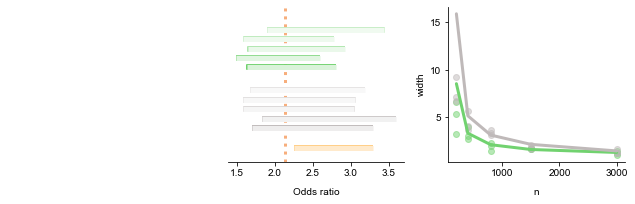

In [6]:
make_plots(df, './plots/alphafold.pdf', intervals_xlabel="Odds ratio", n_idx=4, true_theta=odds_ratio)